![](https://img.shields.io/badge/PO.DAAC-Contribution-%20?color=grey&labelColor=blue)

> From the PO.DAAC Cookbook, to access the GitHub version of the notebook, follow [this link](https://github.com/podaac/tutorials/blob/master/notebooks/datasets/SWOTHR_localmachine.ipynb).

# SWOT Hydrology Dataset Exploration on a local machine

## Accessing and Visualizing SWOT Datasets

### Requirement:
Local compute environment e.g. laptop, server: this tutorial can be run on your local machine.

### Learning Objectives:
- Access SWOT HR data prodcuts (archived in NASA Earthdata Cloud) within the AWS cloud, by downloading to local machine
- Visualize accessed data for a quick check

#### SWOT Level 2 KaRIn High Rate Version 2.0 Datasets:

1. **River Vector Shapefile** - SWOT_L2_HR_RIVERSP_2.0

2. **Lake Vector Shapefile** - SWOT_L2_HR_LAKESP_2.0

3. **Water Mask Pixel Cloud NetCDF** - SWOT_L2_HR_PIXC_2.0

4. **Water Mask Pixel Cloud Vector Attribute NetCDF** - SWOT_L2_HR_PIXCVec_2.0

5. **Raster NetCDF** - SWOT_L2_HR_Raster_2.0

6. **Single Look Complex Data product** - SWOT_L1B_HR_SLC_2.0

_This notebook has been slightly modified by the University of Sherbrooke and University Laval team to run smoothly in Google Colab for the June 16, 2024 training session. Original authors :  Cassie Nickles, NASA PO.DAAC (Feb 2024) || Other Contributors: Zoe Walschots (PO.DAAC Summer Intern 2023), Catalina Taglialatela (NASA PO.DAAC), Luis Lopez (NASA NSIDC DAAC)_

_Last updated: 11 juin 2024_

  

### Libraries Needed

In [ ]:
!pip install contextily
!pip install earthaccess
!pip install --upgrade holoviews hvplot
!pip install holoviews hvplot bokeh xarray
!pip install rioxarray
!pip install rasterio
!pip install shapely
!pip install geoviews
#!pip install hvplot


import glob
import h5netcdf
import xarray as xr
import pandas as pd
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
import hvplot.xarray
import holoviews as hv
import zipfile
import earthaccess
import os
import rioxarray
from shapely.geometry import mapping
import csv
import shapefile
import geoviews as gvts

### Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. If you don't already have one, please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up. We use `earthaccess` to authenticate your login credentials below.

In [ ]:
auth = earthaccess.login()

### Single File Access


#### **1. River Vector Shapefiles**

The https access link can be found using `earthaccess` data search. Since this collection consists of Reach and Node files, we need to extract only the granule for the Reach file. We do this by filtering for the 'Reach' title in the data link.

Alternatively, Earthdata Search [(see tutorial)](https://nasa-openscapes.github.io/2021-Cloud-Workshop-AGU/tutorials/01_Earthdata_Search.html) can be used to manually search in a GUI interface.

For additional tips on spatial searching of SWOT HR L2 data, see also [PO.DAAC Cookbook - SWOT Chapter tips section](https://podaac.github.io/tutorials/quarto_text/SWOT.html#tips-for-swot-hr-spatial-search).



#### Search for the data of interest

In [ ]:
#Retrieves granule from the day we want, in this case by passing to `earthdata.search_data` function the data collection shortname, temporal bounds, and filter by wildcards
river_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_RIVERSP_2.0',
                                        #temporal = ('2024-02-01 00:00:00', '2024-02-29 23:59:59'), # can also specify by time
                                        granule_name = '*Node*_177_NA*') # here we filter by Nodes files (not reachs), by pass=492 (above Nova Scotia) and by continent code=NA
                                                                         # change 'Node' by 'Reach' if you want to extract them instead

Granules found: 10


In [ ]:
#Print the granule characteristics associated with the selected pass.
print(river_results)

#### Dowload, unzip, read the data

Let's download the selected data file! `earthaccess.download` has a list as the input format, so we need to put brackets around the single file we pass.



In [ ]:
earthaccess.download([river_results[3]], "./data_downloads")

The native format for this data is a .zip file, and we want the .shp file within the .zip file, so we must first extract the data to open it. First, we'll programmatically get the filename we just downloaded, and then extract all data to the `data_downloads` folder.

In [ ]:
filename = earthaccess.results.DataGranule.data_links(river_results[3], access='external')
filename = filename[0].split("/")[-1]
filename

'SWOT_L2_HR_RiverSP_Node_010_177_NA_20240131T074748_20240131T074759_PIC0_01.zip'

In [ ]:
with zipfile.ZipFile(f'data_downloads/{filename}', 'r') as zip_ref:
    zip_ref.extractall('data_downloads')

Open the shapefile using `geopandas`

In [ ]:
filename_shp = filename.replace('.zip','.shp')

In [ ]:
SWOT_HR_shp1 = gpd.read_file(f'data_downloads/{filename_shp}')

#view the attribute table
SWOT_HR_shp1

#### Quickly plot the SWOT river data

In [ ]:
# Simple plot
fig, ax = plt.subplots(figsize=(10,10))
SWOT_HR_shp1.plot(ax=ax, color='black')
cx.add_basemap(ax, crs=SWOT_HR_shp1.crs, source=cx.providers.OpenTopoMap)

In [ ]:
# Another way to plot geopandas dataframes is with `explore`, which also plots a basemap
#SWOT_HR_shp1.explore()

#### **2. Lake Vector Shapefiles**

The lake vector shapefiles can be accessed in the same way as the river shapefiles above.

For additional tips on spatial searching of SWOT HR L2 data, see also [PO.DAAC Cookbook - SWOT Chapter tips section](https://podaac.github.io/tutorials/quarto_text/SWOT.html#tips-for-swot-hr-spatial-search).

#### Search for data of interest

In [ ]:
lake_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_LAKESP_2.0',
                                        #temporal = ('2024-02-01 00:00:00', '2024-02-29 23:59:59'), # can also specify by time
                                        granule_name = '*Obs*_177_NA*') # here we filter by files with 'Obs' in the name (This collection has three options: Obs, Unassigned, and Prior), by pass #535 (Halifax region) and by continent code=NA

Granules found: 9


In [ ]:
#Print the granule characteristics associated with the selected pass.
print(lake_results)

Let's download the selected data file! For the formation purposes, let's download a granule from the Halifax region. earthaccess.download has a list as the input format, so we need to put brackets around the single file we pass.

In [ ]:
earthaccess.download([lake_results[0]], "./data_downloads")

The native format for this data is a .zip file, and we want the .shp file within the .zip file, so we must first extract the data to open it. First, we'll programmatically get the filename we just downloaded, and then extract all data to the `SWOT_downloads` folder.

In [ ]:
filename2 = earthaccess.results.DataGranule.data_links(lake_results[0], access='external')
filename2 = filename2[0].split("/")[-1]
filename2

In [ ]:
with zipfile.ZipFile(f'data_downloads/{filename2}', 'r') as zip_ref:
    zip_ref.extractall('data_downloads')

Open the shapefile using `geopandas`

In [ ]:
filename_shp2 = filename2.replace('.zip','.shp')
filename_shp2

In [ ]:
SWOT_HR_shp2 = gpd.read_file(f'data_downloads/{filename_shp2}')

#view the attribute table
SWOT_HR_shp2

#### Quickly plot the SWOT lakes data

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
SWOT_HR_shp2.plot(ax=ax, color='black')
ax.set_ylim(50.6,54.7) #select your area of interest to zoom in
ax.set_xlim(-108,-104) #select your area of interest to zoom in
cx.add_basemap(ax, crs=SWOT_HR_shp2.crs, source=cx.providers.OpenTopoMap)


Accessing the remaining files is different than the shp files above. We do not need to extract the shapefiles from a zip file because the following SWOT HR collections are stored in **netCDF** files in the cloud. For the rest of the products, we will open via `xarray`, not `geopandas`.

#### **3. Water Mask Pixel Cloud NetCDF**

#### Search for data collection and time of interest

In [ ]:
pixc_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXC_2.0',
                                        #temporal = ('2024-02-01 00:00:00', '2024-02-29 23:59:59'), # can also specify by time
                                        granule_name = '*_328_061R*') # pass number 535, tile number 233, left swath (Halifax region)
                                        #bounding_box = (-107.781372,52.298402,-105.545654,52.958566)) # filter by bouding box EX : Shubenacadie Grand Lake near Halifax, to find your bounding box : http://bboxfinder.com/

In [ ]:
#Print the granule characteristics associated with the selected pass, tile and swath.
print(pixc_results)

Let's download one data file! earthaccess.download has a list as the input format, so we need to put brackets around the single file we pass.

In [ ]:
earthaccess.download([pixc_results[1]], "./data_downloads")

#### Open data using xarray





The pixel cloud netCDF files are formatted with three groups titled, "pixel cloud", "tvp", or "noise" (more detail [here](https://podaac-tools.jpl.nasa.gov/drive/files/misc/web/misc/swot_mission_docs/pdd/D-56411_SWOT_Product_Description_L2_HR_PIXC_20200810.pdf)). In order to access the coordinates and variables within the file, a group must be specified when calling xarray open_dataset.

In [ ]:
ds_PIXC = xr.open_mfdataset("data_downloads/SWOT_L2_HR_PIXC_*.nc", group = 'pixel_cloud', engine='h5netcdf') #If several PIXC files are uploaded to the data_downlaod file, specify which of the files to display
ds_PIXC


#### Simple plot of the results

In [ ]:
# This could take a few minutes to plot
fig, ax = plt.subplots(figsize=(10, 10))
cax=plt.scatter(x=ds_PIXC.longitude, y=ds_PIXC.latitude, c=ds_PIXC.height, s=1) #adjust pixel size with s= desired size
cbar = fig.colorbar(cax, ax=ax, shrink=0.5)
cbar.set_label('Height (m)')

# adjust colobar
cbar.ax.set_aspect('auto')

cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.OpenTopoMap)




#### Crop and Convert PIXC into a shapefile to open in QGIS

In [ ]:
from shapely.geometry import Point, Polygon

lat_min = 52.55
lat_max = 52.75
lon_min = -106.4
lon_max = -106.1

lat = np.asarray(ds_PIXC.latitude[:])
lon = np.asarray(ds_PIXC.longitude[:])


mask = (lat > lat_min) & (lat < lat_max) & (lon > lon_min) & (lon < lon_max)

data = {}
exclude_vars = ['interferogram', 'illumination_time','illumination_time_tai','pixc_line_qual', 'pixc_line_to_tvp','data_window_first_valid','data_window_last_valid','data_window_first_cross_track','data_window_last_cross_track']
for var_name in ds_PIXC.variables:
    if var_name not in exclude_vars:
        var_data = np.asarray(ds_PIXC.variables[var_name][:])
        var_data = var_data[mask]
        if len(var_data.shape) > 1:
            var_data = var_data.reshape(-1)
        data[var_name] = var_data

df = pd.DataFrame(data)

points = [Point(x, y) for x, y in zip(df.longitude, df.latitude)]

gdf_out = gpd.GeoDataFrame(df, geometry=points, crs="EPSG:4326")
out_shp= './data_downloads/SWOT_L2_HR_PIXC_002_328_061R_20230822T185205_20230822T185216_PGC0_01.shp'
gdf_out.to_file(out_shp)


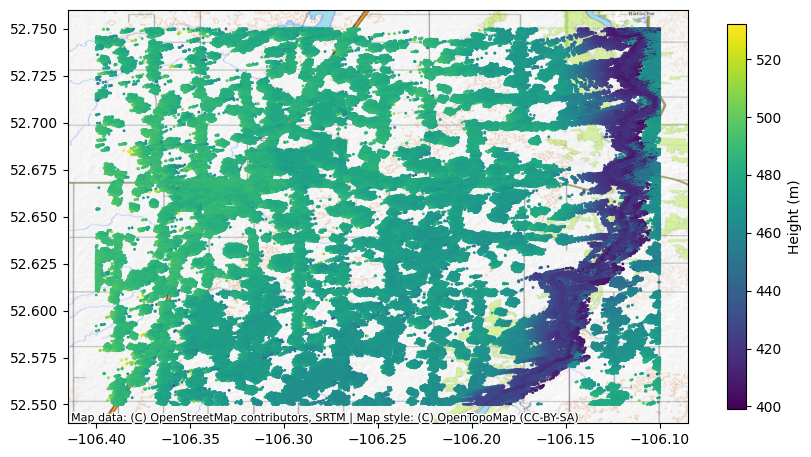

In [ ]:
# Plot your masked PIXC data . You can also download the Shapefile and visualized it in QGIS
fig, ax = plt.subplots(figsize=(10, 10))
cax= plt.scatter(x=gdf_out.longitude, y=gdf_out.latitude, c=gdf_out.height, s=1) #adjust pixel size with s= desired size
cbar = fig.colorbar(cax, ax=ax, shrink=0.5)
cbar.set_label('Height (m)')

# adjust colobar
cbar.ax.set_aspect('auto')

cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.OpenTopoMap)



#### **4. Water Mask Pixel Cloud Vector Attribute NetCDF**

#### Search for data of interest

In [ ]:
pixcvec_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXCVEC_2.0',
                                        #temporal = ('2024-02-01 00:00:00', '2024-02-29 23:59:59'), # can also specify by time
                                        granule_name = '*_328_061R*') # pass number 535, tile number 233, left swath
                                        #bounding_box = (-107.781372,52.298402,-105.545654,52.958566)) # filter by bouding box EX : Shubenacadie Grand Lake near Halifax, to find your bounding box : http://bboxfinder.com/


Granules found: 9


In [ ]:
#Print the granule characteristics.
print(pixcvec_results)

Let's download the first data file! earthaccess.download has a list as the input format, so we need to put brackets around the single file we pass.

In [ ]:
earthaccess.download([pixcvec_results[0]], "./data_downloads")

#### Open data using xarray

First, we'll programmatically get the filename we just downloaded and then view the file via `xarray`.

In [ ]:
ds_PIXCVEC = xr.open_mfdataset("data_downloads/SWOT_L2_HR_PIXCVec_*.nc", decode_cf=False,  engine='h5netcdf')
ds_PIXCVEC

#### Simple plot

In [ ]:
pixcvec_htvals = ds_PIXCVEC.height_vectorproc.compute()
pixcvec_latvals = ds_PIXCVEC.latitude_vectorproc.compute()
pixcvec_lonvals = ds_PIXCVEC.longitude_vectorproc.compute()

#Before plotting, we set all fill values to nan so that the graph shows up better spatially
pixcvec_htvals[pixcvec_htvals > 15000] = np.nan
pixcvec_latvals[pixcvec_latvals < 1] = np.nan
pixcvec_lonvals[pixcvec_lonvals > -1] = np.nan


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x=pixcvec_lonvals, y=pixcvec_latvals, c=pixcvec_htvals, s=1) #adjust pixel size with s= desired size
plt.colorbar().set_label('Height (m)')

cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.OpenTopoMap)
plt.show()

#### **5. Raster NetCDF**

#### Search for data of interest

In [ ]:
raster_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_Raster_2.0',
                                        #temporal = ('2024-02-01 00:00:00', '2024-02-29 23:59:59'), # can also specify by time
                                        #bounding_box = (-63.83,44.82,-63.36,44.99), # filter by bouding box EX : Shubenacadie Grand Lake near Halifax, to find your bounding box : http://bboxfinder.com/
                                        granule_name = '*100m*_205_124F*') # here we filter by files with '100m' in the name (This collection has two resolution options: 100m & 250m)



Granules found: 9


In [ ]:
#Print the granule characteristics associated with the selected pass, scene and resolution.
print(raster_results)

Let's download one data file.

In [ ]:
earthaccess.download([raster_results[1]], "./data_downloads")

#### Open data with xarray

First, we'll programmatically get the filename we just downloaded and then view the file via `xarray`.

In [ ]:
ds_raster = xr.open_mfdataset(f'data_downloads/SWOT_L2_HR_Raster*', engine='h5netcdf')
ds_raster

#### Quick interactive plot with `hvplot`

In [ ]:
hv.extension('bokeh', 'matplotlib')
plot = ds_raster['wse'].hvplot.image(y='y', x='x')
hv.output(plot)



#### Masking a variable with its quality flag
Example for L2_HR_Raster, flag "wse_qual":\
0 = good\
1 = suspect - may have large errors\
2 = degraded - likely to have large errors\
3 = bad - may be nonsensical and should be ignored

In [ ]:
variable_to_mask = ds_raster['wse']
mask_variable = ds_raster['wse_qual']


In [ ]:
# Define the condition for masking based on the range of the quality flag
mask_condition = mask_variable < 3
masked_variable = variable_to_mask.where(mask_condition)
masked_variable


In [ ]:
# Update the masked variable in the dataset
hv.extension('bokeh', 'matplotlib')
plot2 = masked_variable.hvplot.image(y='y', x='x')
hv.output(plot2)


In [ ]:
!pip install geoviews

#### Clip your Masked Raster NetCDF data

In [ ]:
# Create a file for your clipped data
os.makedirs('./content/clip_data', exist_ok=True)

In [ ]:
#Define the area of interest
from shapely.geometry import box

ROI = box(-107.34,52.60,-106.97,52.77)
bbox_gdf = gpd.GeoDataFrame({'geometry': [ROI]}, crs='EPSG:4326')


In [ ]:
# Enter the path of your data
# Set the dataset’s spatial dimensions and the coordinate reference system(crs).
masked_variable.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
masked_variable.rio.write_crs("epsg:32613", inplace=True)


In [ ]:
# Clip the raster
# If necessary, first reproject the ROI to the same EPSG as the netCDF one
bbox_gdf = bbox_gdf.to_crs("epsg:32613")
clipped = masked_variable.rio.clip(bbox_gdf.geometry.apply(mapping), drop=True)

#plot to check the cropped ROI
hv.extension('bokeh', 'matplotlib')
plot2 = clipped.hvplot.image(y='y', x='x')
hv.output(plot2)


In [ ]:
# Remove the 'grid_mapping' attribute
if 'grid_mapping' in clipped.attrs:
    del clipped.attrs['grid_mapping']

# Save the clipped raster to a NetCDF file
clipped_path = './content/clip_data/clipped_raster.nc'  # Set the path and the name of the file to save the clipped NetCDF
clipped.to_netcdf(clipped_path)

#### **6. Transformation of reference systems**





The reference system of SWOT is not the same that the one of Canada. Therefore, there is a need to convert the data.
**Warning : Each Canadian provincial geodetic agency can adopt a different vertical reference system and epoch!**


Clip the data with the Saskatchewan mask (needed because each province can adopt a different epoch and vertical reference system)

Warning : change the name of the RiverSp file to match the one you want


In [ ]:
import os
os.makedirs('ref_change', exist_ok=True)

# Step 1: Load the GeoJSON file with the provinces
url = 'https://data.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-canada-province@public/exports/geojson?lang=fr&timezone=America%2FNew_York'

gdf_prov = gpd.read_file(url)

# Step 2: Filter the GeoDataFrame to select only Saskatchewan province
saskatchewan_gdf = gdf_prov[gdf_prov['prov_name_fr'] == 'Saskatchewan']

print(saskatchewan_gdf.geometry)


In [ ]:
# Load the shapefile to be clipped and verify that the mask and the RiverSP file have the same coordinate system
from shapely.ops import unary_union

shapefile_path = '/content/data_downloads/SWOT_L2_HR_RiverSP_Node_010_177_NA_20240131T074748_20240131T074759_PIC0_01.shp'

points_gdf = gpd.read_file(shapefile_path)

saskatchewan_gdf = saskatchewan_gdf.to_crs(points_gdf.crs)

points_gdf_masked = points_gdf.clip(mask= saskatchewan_gdf.geometry)

#Save your selected nodes to SHP format
points_gdf_masked.to_file('/content/ref_change/sask_nodes.shp')



Plot your cropped data

In [ ]:
# Simple plot
fig, ax = plt.subplots(figsize=(7,5))
points_gdf_masked.plot(ax=ax, color='black')
saskatchewan_gdf.boundary.plot(ax=ax, edgecolor='red')
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenTopoMap)

Then, the data must be extracted and saved in the rigth format to use it with the TRX tool from NRCan

In [ ]:
# Enter the path of your data
data_all = []

with shapefile.Reader('/content/ref_change/sask_nodes.shp') as shp:

    fields = [field[0] for field in shp.fields if field[0] != 'DeletionFlag']

    for record in shp.records():
          attributs = dict(zip(fields, record))
          #Select the node_id, latitude, longitude and wse that arenot -999999999999
          if all(value != -999999999999 for value in attributs.values()):
            data_all.append([attributs['node_id'],attributs['lat'],attributs['lon'],attributs['wse']])

header = ['Station','latitude','longitude','height']

# Creation and writing CSV file
with open('/content/ref_change/wse_sask.csv', 'w', newline='', encoding='utf-8') as fichier:
    writer = csv.writer(fichier)
    writer.writerow(header)

    # Data writing
    for data in data_all:
        writer.writerow(data)

#Save on the computer
from google.colab import files
files.download("/content/ref_change/wse_sask.csv")

Finally, to use TRX online, go to the website : https://webapp.csrs-scrs.nrcan-rncan.gc.ca/geod/tools-outils/trx.php?locale=en


Fill this informations in the **Batch proccesing** window:

**Origin** : Reference Frame : ITRF2014 epoque 01/01/2010

**Destination** : Reference Frame : NAD83(CSRS) Coordinates : Geographic

 **Epoch Transformation** : 01/01/1997 (adopted epoch for Saskatchewan, adapt the epoch accordingly)

Select the file downloaded previously.

#### **7. Download all your SWOT data to your local computer at once**






You can download data one by one by clicking on the three small dots to the right of the file name and then on “Download”. To download all the data at once, run the following cells. Execution and downlaod times may be long.

In [ ]:
# Create a zip file with all data and choose the file to compress
!zip -r /content/data.zip /content/data_downloads

In [ ]:
# Download data zip file
from google.colab import files
files.download("/content/data.zip")


#### **8. Working with HYDROCON**


Extract time series from Hydrocon for your Reache or node of interest

In [ ]:
from ast import And
import folium
import requests
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

# You can choose a node id from the RiverSP product obtained in section 1
#Example for South Saskatchewan River

#feature='Node'
#feature_id="71250300150401"
feature="Reach"
feature_id="71250300151"
#start_time="2024-01-01T00:00:00Z"
#end_time="2024-06-06T00:00:00Z"
#fields=reach_id,time_str,wse,width

parameters = "https://soto.podaac.earthdatacloud.nasa.gov/hydrocron/v1/timeseries?feature="+feature+"&feature_id="+ feature_id +"&start_time=2024-01-01T00:00:00Z&end_time=2024-06-06T00:00:00Z&output=geojson&fields=reach_id,time_str,wse,width,cycle_id"

hydrocron_response = requests.get(
    parameters
).json()

hydrocron_response

# extract just the geojson to plot on the map

geojson_data = hydrocron_response['results']['geojson']

geojson_data

# Set up the map using Folium (https://python-visualization.github.io/folium/latest/)

map = folium.Map (zoom_start=13, tiles="cartodbpositron", width=700, height=700)

# add the geojson from Hydrocron to the map
folium.GeoJson(geojson_data, name='SWOT River Reach').add_to(map)
folium.LayerControl().add_to(map)

# zoom to the river feature we added
map.fit_bounds(map.get_bounds(), padding=(5, 5))

map


Plot time series of WSE for a chosen Node

<ipython-input-2-7d561b6f9271>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.time_str = pd.to_datetime(df.time_str, format='%Y-%m-%dT%H:%M:%SZ')


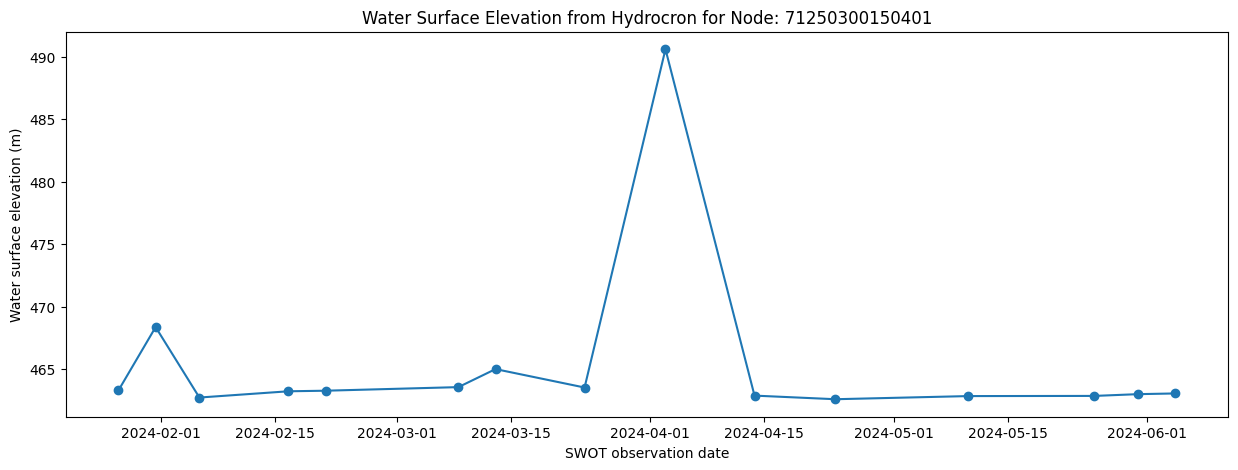

In [ ]:
#Example for South Saskatchewan River

feature='Node'
feature_id="71250300150401"
#start_time="2024-01-01T00:00:00Z"
#end_time="2024-06-06T00:00:00Z"
#fields=reach_id,time_str,wse,width

parameters = "https://soto.podaac.earthdatacloud.nasa.gov/hydrocron/v1/timeseries?feature="+feature+"&feature_id="+ feature_id +"&start_time=2024-01-01T00:00:00Z&end_time=2024-06-14T00:00:00Z&output=csv&fields=reach_id,node_id,time_str,node_q,wse,width,cycle_id"

hydrocron_response = requests.get(
    parameters
).json()

hydrocron_response
csv_str = hydrocron_response['results']['csv']
df = pd.read_csv(StringIO(csv_str))
ind = df.node_q<3

df = df[df['time_str'] != 'no_data']
df.time_str = pd.to_datetime(df.time_str, format='%Y-%m-%dT%H:%M:%SZ')
fig = plt.figure(figsize=(15,5))
plt.plot(df.time_str[ind], df.wse[ind], marker='o')

plt.ylabel('Water surface elevation (m)')
plt.xlabel('SWOT observation date')
plt.title('Water Surface Elevation from Hydrocron for Node: ' + str(df.node_id[0]))

#Save your image
plt.savefig('/content/WSE_Hydrocon.png')
